# Testing Distributions

This notebook illustrates basic descriptive stats (means, std, skewness, kurtosis), histograms, the Bera-Jarque test (of normality), Q-Q plots and tests of the empirical distribution function (Kolmogorov-Smirnov).

You may also consider the [HypothesisTests.jl](https://github.com/JuliaStats/HypothesisTests.jl) package.

## Load Packages and Extra Functions

In [1]:
using Dates, DelimitedFiles, Distributions, StatsBase

include("jlFiles/printmat.jl")

printwhere (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))             #pyplot() or gr()
gr(size=(480,320))
default(fmt = :svg)

# Load Data from a csv File

In [3]:
xx  = readdlm("Data/FFdFactors.csv",',',skipstart=1)
x   = xx[:,2]            #equity market excess returns
xx  = nothing

T   = size(x,1)
println("Sample size: $T")

Sample size: 15356


## Basic Descriptive Statistics and a Histogram

The next few cells estimate means, standard deviations, covariances and correlations of the variables `Rme` (US equity market excess return) and `Re` (excess returns for a segment of the market, small growth firms). 

In [4]:
μ = mean(x)
σ = std(x)
(xmin,xmax) = extrema(x)

printblue("Basic descriptive stats:")
xx = [μ,σ,xmin,xmax]
printTable(xx,[""],["μ","σ","min","max"])

Basic descriptive stats:
             
μ       0.026
σ       0.955
min   -17.440
max    11.350



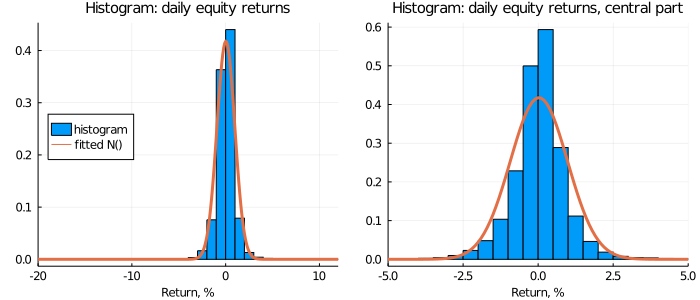

In [5]:
xGrid = -20:0.1:12
pdfX  = pdf.(Normal(μ,σ),xGrid) #"Distributions" wants σ, not σ^2

p1 = histogram( x,bins = -20:1:12,
                normalized = true,     #normalized to have area=1
                label = "histogram",
                legend = :left,
                xlim = (-20,12),
                title = "Histogram: daily equity returns",
                titlefont = font(10),
                xlabel = "Return, %",
                guidefont = font(8) )
plot!(xGrid,pdfX,linewidth=3,label="fitted N()")

p2 = histogram( x,bins = -5:0.5:5,
                normalized = true,
                legend = false,
                xlim = (-5,5),
                title = "Histogram: daily equity returns, central part",
                titlefont=font(10),
                xlabel = "Return, %",
                guidefont=font(8) )
plot!(xGrid,pdfX,linewidth=3,legend=false)

pAll = plot(p1,p2,layout=(1,2),size=(700,300))                  #set up subplots
display(pAll)

# Skewness, Kurtosis and the Bera-Jarque Test

In [6]:
xStd     = (x .- μ)./σ               #first normalize to a zero mean, unit std variable
skewness = mean(xStd.^3)
kurtosis = mean(xStd.^4)

BJ     = (T/6)*skewness.^2 + (T/24)*(kurtosis.-3).^2  #chi2(2)
#pvalBJ = 1 .- cdf.(Chisq(2),BJ)

printblue("More descriptive stats:")
xx = [skewness,kurtosis,BJ]
printTable(xx,[""],["Skewness","Kurtosis","Bera-Jarque"],width=12)

More descriptive stats:
                       
Skewness         -0.519
Kurtosis         19.166
Bera-Jarque  167896.608



# Q-Q Plot

The Q-Q plot shows the empirical quantiles against the theoretical quantiles (possible from an estimated distribution). If the theoretical distribution is a good fit to the data, then the results should cluster closely around a 45 degree line.

In [7]:
pval1 = 0.01:0.01:0.99                          #quantiles 0.01 to 0.99, to QQ plot
pval2 = [0.001:0.001:0.009;0.991:0.001:0.999]   #extreme quantiles

qEmp1 = quantile(x,pval1)                       #empirical quantiles
qEmp2 = quantile(x,pval2) 
qN1   = quantile.(Normal(μ,σ),pval1)            #quantiles of N()
qN2   = quantile.(Normal(μ,σ),pval2);           #quantiles of N()

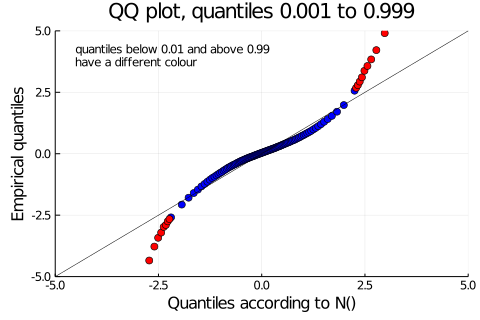

In [8]:
txt = text("quantiles below 0.01 and above 0.99\nhave a different colour",8,:left)

p1 = scatter( qN1,qEmp1,color=:blue,legend=false,
              xlim = (-5,5),
              ylim = (-5,5),
              title = "QQ plot, quantiles 0.001 to 0.999",
              xlabel = "Quantiles according to N()",
              ylabel = "Empirical quantiles",
              annotation = (-4.5,4,txt) )
scatter!(qN2,qEmp2,color=:red,legend=false)
plot!([-5,5],[-5,5],color=:black,linewidth=0.5)
display(p1)

# Empirical Distribution Function and the Kolmogorov-Smirnov Test

The empirical distribution function (edf) shows the empirical quantiles. The K-S test is designed to show whether the edf differs from a theoretical (possibly estimated) cdf.

In [9]:
xSorted = sort(x)

edfFn = ecdf(xSorted)

edfEmp = edfFn(xGrid)                   #just for xGrid, for plotting
cdfN   = cdf.(Normal(μ,σ),xGrid);

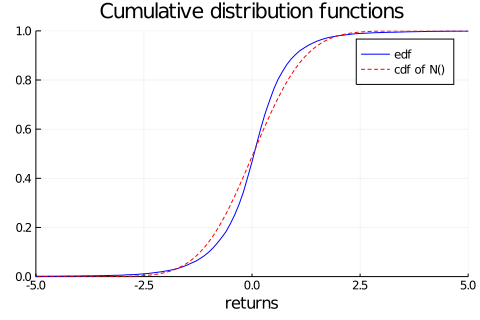

In [10]:
p1 = plot( xGrid,[edfEmp cdfN],
          label = ["edf" "cdf of N()"],
          linecolor = [:blue :red],
          linestyle = [:solid :dash],
          title = "Cumulative distribution functions",
          xlabel = "returns",
          xlim = (-5,5),
          ylim = (0,1) )
display(p1)

In [11]:
function KolSmirPs(x1,TheoryCdf::Function)
    T            = length(x1)
    x1Sorted     = sort(x1)
    TheoryCdf_x  = TheoryCdf.(x1Sorted)
    edfH         = 1/T:1/T:1                        #empirical cdf for x1Sorted
    edfL         = 0:1/T:(1-1/T)
    D_candidates = abs.([edfH;edfL] - repeat(TheoryCdf_x,2))
    (D,vD)       = findmax(D_candidates)
    KSstat       = sqrt(T)*D 
    return KSstat
end

KolSmirPs (generic function with 1 method)

In [12]:
KSstat = KolSmirPs(x,z->cdf(Normal(μ,σ),z))

printblue("Kolmogorov-Smirnov test:")
printTable([KSstat 1.36],["sqrt(T)*D","5% critval"],[""],width=12)

Kolmogorov-Smirnov test:
   sqrt(T)*D  5% critval
       9.941       1.360

